## Importing Libraries and setting up enviroment

In [1]:
#libraries
import shutil
from collections import OrderedDict
import json
import numpy as np

#visualization of the dataset

import pandas as pd
import seaborn as sns
import SimpleITK as sitk

import sys
import os
sys.path.append('..')
from utils import haussdorf, avd, rel_abs_vol_dif, dice_score, create_special_trainer, check_gpu, graph_brain, convert_data_structure, create_dataset_json




## Running custom scripts

In [2]:
file_path = "nnUNet/nnunet/training/network_training/nnUNetTrainerV2_Fast.py"
create_special_trainer(file_path)

The file nnUNetTrainerV2_Fast exists, do nothing.


In [2]:
convert_data_structure('../TrainingValidationTestSets/','nnUNet_raw/nnUNet_raw_data/')

New data structure already exists


In [3]:
create_dataset_json('nnUNet_raw/nnUNet_raw_data/Task975_BrainSegmentation/', "nnUNet_raw/nnUNet_raw_data/Task975_BrainSegmentation/dataset.json")

File 'nnUNet_raw/nnUNet_raw_data/Task975_BrainSegmentation/dataset.json' already exists. No action taken.


In [1]:
! git clone https://github.com/MIC-DKFZ/nnUNet.git

Cloning into 'nnUNet'...
remote: Enumerating objects: 11351, done.
remote: Counting objects: 100% (400/400), done.
remote: Compressing objects: 100% (222/222), done.
remote: Total 11351 (delta 244), reused 291 (delta 176), pack-reused 10951
Receiving objects: 100% (11351/11351), 5.50 MiB | 6.94 MiB/s, done.
Resolving deltas: 100% (8635/8635), done.


In [1]:
! cd nnUNet; git checkout nnunetv1

Already on 'nnunetv1'
Your branch is up to date with 'origin/nnunetv1'.


In [2]:
! cd nnUNet; pip install -e .

Obtaining file:///home/edalita/Documents/MAIA/3-Semestre/MIRMISAProject/IBSR18-tissue-segmentation/dl_part/nnUNet
  Preparing metadata (setup.py) ... done
  Using cached argparse-1.4.0-py2.py3-none-any.whl (23 kB)
  Attempting uninstall: nnunet
    Found existing installation: nnunet 1.7.0
    Uninstalling nnunet-1.7.0:
      Successfully uninstalled nnunet-1.7.0
  Running setup.py develop for nnunet


In [5]:
! nvidia-smi

Tue Jan  9 22:20:02 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1050 Ti     Off | 00000000:01:00.0 Off |                  N/A |
| N/A   43C    P8              N/A / ERR! |      6MiB /  4096MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
check_gpu()

_____Python, Pytorch, Cuda info____
__Python VERSION: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
__pyTorch VERSION: 2.1.1+cu121
__CUDA RUNTIME API VERSION
__CUDNN VERSION: 8902
_____nvidia-smi GPU details____
index, name, driver_version, memory.total [MiB], memory.used [MiB], memory.free [MiB]
0, NVIDIA GeForce GTX 1050 Ti, 535.146.02, 4096 MiB, 6 MiB, 4034 MiB
_____Device assignments____
Number CUDA Devices: 1
Current cuda device:  0  **May not correspond to nvidia-smi ID above, check visibility parameter
Device name:  NVIDIA GeForce GTX 1050 Ti


## nnUNet_raw should exists since it is on the github
### Create Manually the other two folders the results and preprocessed

In [7]:
base_dir = os.getcwd()
nnUNet_raw = os.path.join(base_dir,'nnUNet_raw')
nnUNet_preprocessed = os.path.join(base_dir,'nnUNet_preprocessed')
results_folder = os.path.join(base_dir,'nnUNet_results')

In [8]:
print(nnUNet_raw) #Check the directory address is correct

/home/edalita/Documents/MAIA/3-Semestre/MIRMISAProject/IBSR18-tissue-segmentation/dl_part/nnUNet_raw


In [9]:
os.environ["nnUNet_raw_data_base"] = str(nnUNet_raw)
os.environ["nnUNet_preprocessed"] = str(nnUNet_preprocessed)
os.environ["RESULTS_FOLDER"] = str(results_folder)

## Checking the data and preparing for the trainning

In [10]:
! nnUNet_plan_and_preprocess -t 975 --verify_dataset_integrity



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet

Verifying training set
checking case IBSR_01
checking case IBSR_02
checking case IBSR_03
checking case IBSR_04
checking case IBSR_05
checking case IBSR_06
checking case IBSR_07
checking case IBSR_08
checking case IBSR_09
checking case IBSR_10
checking case IBSR_11
checking case IBSR_12
checking case IBSR_13
checking case IBSR_14
checking case IBSR_15
Verifying label values
Expected label values are [0, 1, 2, 3]
Labels OK
Verifying test set
Dataset OK
IBSR_01
IBSR_02
IBSR_03
IBSR_04
IBSR_05
IBSR_06
IBSR_09
IBSR_10
IBSR_12IBSR_11

IBSR_08
IBSR_13IBSR_07

IBSR_14
IBSR_15



 Task975_BrainSegmentation
number of threads:  (8, 8) 

usin

## Training
- To train - nnUNet_train TRAINER_CLASS_NAME TASK_NAME_OR_ID FOLD
- To resume - nnUNet_train TRAINER_CLASS_NAME TASK_NAME_OR_ID FOLD -c (just add -c to the training command)
- TRAINER_CLASS_NAME - 2d, 3d_fullres, 3d_lowres, 3d_cascade_fullres
- Everything will be stored in the results folder

In [10]:
! nnUNet_train -h



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet

usage: nnUNet_train [-h] [-val] [-c] [-p P] [--use_compressed_data]
                    [--deterministic] [--npz] [--find_lr] [--valbest] [--fp32]
                    [--val_folder VAL_FOLDER] [--disable_saving]
                    [--disable_postprocessing_on_folds]
                    [--disable_validation_inference] [--val_disable_overwrite]
                    [--disable_next_stage_pred]
                    [-pretrained_weights PRETRAINED_WEIGHTS]
                    network network_trainer task fold

positional arguments:
  network
  network_trainer
  task                  can be task name or task id
  fold                  0

In [11]:
! nnUNet_train 2d nnUNetTrainerV2_Fast Task975_BrainSegmentation 3 --npz -c 



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet

###############################################
I am running the following nnUNet: 2d
My trainer class is:  <class 'nnunet.training.network_training.nnUNetTrainerV2_Fast.nnUNetTrainerV2_Fast'>
For that I will be using the following configuration:
num_classes:  3
modalities:  {0: 'T1'}
use_mask_for_norm OrderedDict([(0, True)])
keep_only_largest_region None
min_region_size_per_class None
min_size_per_class None
normalization_schemes OrderedDict([(0, 'nonCT')])
stages...

stage:  0
{'batch_size': 69, 'num_pool_per_axis': [5, 5], 'patch_size': array([160, 160]), 'median_patient_size_in_voxels': array([115, 139, 147]), 'current_spacin

In [12]:
! nnUNet_train 2d nnUNetTrainerV2_Fast Task975_BrainSegmentation 0 --npz -c



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet

###############################################
I am running the following nnUNet: 2d
My trainer class is:  <class 'nnunet.training.network_training.nnUNetTrainerV2_Fast.nnUNetTrainerV2_Fast'>
For that I will be using the following configuration:
num_classes:  3
modalities:  {0: 'T1'}
use_mask_for_norm OrderedDict([(0, True)])
keep_only_largest_region None
min_region_size_per_class None
min_size_per_class None
normalization_schemes OrderedDict([(0, 'nonCT')])
stages...

stage:  0
{'batch_size': 69, 'num_pool_per_axis': [5, 5], 'patch_size': array([160, 160]), 'median_patient_size_in_voxels': array([115, 139, 147]), 'current_spacin

In [13]:
! nnUNet_train 2d nnUNetTrainerV2_Fast Task975_BrainSegmentation 1 --npz -c



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet

###############################################
I am running the following nnUNet: 2d
My trainer class is:  <class 'nnunet.training.network_training.nnUNetTrainerV2_Fast.nnUNetTrainerV2_Fast'>
For that I will be using the following configuration:
num_classes:  3
modalities:  {0: 'T1'}
use_mask_for_norm OrderedDict([(0, True)])
keep_only_largest_region None
min_region_size_per_class None
min_size_per_class None
normalization_schemes OrderedDict([(0, 'nonCT')])
stages...

stage:  0
{'batch_size': 69, 'num_pool_per_axis': [5, 5], 'patch_size': array([160, 160]), 'median_patient_size_in_voxels': array([115, 139, 147]), 'current_spacin

In [14]:
! nnUNet_train 2d nnUNetTrainerV2_Fast Task975_BrainSegmentation 2 --npz -c 



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet

###############################################
I am running the following nnUNet: 2d
My trainer class is:  <class 'nnunet.training.network_training.nnUNetTrainerV2_Fast.nnUNetTrainerV2_Fast'>
For that I will be using the following configuration:
num_classes:  3
modalities:  {0: 'T1'}
use_mask_for_norm OrderedDict([(0, True)])
keep_only_largest_region None
min_region_size_per_class None
min_size_per_class None
normalization_schemes OrderedDict([(0, 'nonCT')])
stages...

stage:  0
{'batch_size': 69, 'num_pool_per_axis': [5, 5], 'patch_size': array([160, 160]), 'median_patient_size_in_voxels': array([115, 139, 147]), 'current_spacin

In [15]:
! nnUNet_train 2d nnUNetTrainerV2_Fast Task975_BrainSegmentation 4 --npz -c



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet

###############################################
I am running the following nnUNet: 2d
My trainer class is:  <class 'nnunet.training.network_training.nnUNetTrainerV2_Fast.nnUNetTrainerV2_Fast'>
For that I will be using the following configuration:
num_classes:  3
modalities:  {0: 'T1'}
use_mask_for_norm OrderedDict([(0, True)])
keep_only_largest_region None
min_region_size_per_class None
min_size_per_class None
normalization_schemes OrderedDict([(0, 'nonCT')])
stages...

stage:  0
{'batch_size': 69, 'num_pool_per_axis': [5, 5], 'patch_size': array([160, 160]), 'median_patient_size_in_voxels': array([115, 139, 147]), 'current_spacin

In [16]:
! nnUNet_train 2d nnUNetTrainerV2_Fast Task975_BrainSegmentation 5 --npz -c



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet

###############################################
I am running the following nnUNet: 2d
My trainer class is:  <class 'nnunet.training.network_training.nnUNetTrainerV2_Fast.nnUNetTrainerV2_Fast'>
For that I will be using the following configuration:
num_classes:  3
modalities:  {0: 'T1'}
use_mask_for_norm OrderedDict([(0, True)])
keep_only_largest_region None
min_region_size_per_class None
min_size_per_class None
normalization_schemes OrderedDict([(0, 'nonCT')])
stages...

stage:  0
{'batch_size': 69, 'num_pool_per_axis': [5, 5], 'patch_size': array([160, 160]), 'median_patient_size_in_voxels': array([115, 139, 147]), 'current_spacin

## Evaluation of the Validation Results

In [17]:
! nnUNet_find_best_configuration -m 2d -t 975 -tr nnUNetTrainerV2_Fast



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet


I will now ensemble combinations of the following models:
 ['2d']
2d 0.929296028022764
Task975_BrainSegmentation submit model 2d 0.929296028022764

Here is how you should predict test cases. Run in sequential order and replace all input and output folder names with your personalized ones

nnUNet_predict -i FOLDER_WITH_TEST_CASES -o OUTPUT_FOLDER_MODEL1 -tr nnUNetTrainerV2_Fast -ctr nnUNetTrainerV2CascadeFullRes -m 2d -p nnUNetPlansv2.1 -t Task975_BrainSegmentation



In [18]:
for i in range(6):
  preds_path_2d = f'nnUNet_results/nnUNet/2d/Task975_BrainSegmentation/nnUNetTrainerV2_Fast__nnUNetPlansv2.1/fold_{i}/validation_raw_postprocessed'
  gt_path_2d = 'nnUNet_results/nnUNet/2d/Task975_BrainSegmentation/nnUNetTrainerV2_Fast__nnUNetPlansv2.1/gt_niftis'

  # List all files in the folder
  file_list = os.listdir(preds_path_2d)
  val_list = [file.replace(".nii.gz", "") for file in file_list if file.endswith(".nii.gz")]
  print(f'Fold {i}')
  print(val_list)
  for img_id in val_list:
    gt = sitk.ReadImage(f'{gt_path_2d}/{img_id}.nii.gz')
    vspace = gt.GetSpacing()
    gt = sitk.GetArrayFromImage(gt)
    pred = sitk.GetArrayFromImage(sitk.ReadImage(f'{preds_path_2d}/{img_id}.nii.gz'))
    HF = haussdorf(gt, pred, vspace)
    AVD = avd(gt, pred, vspace)
    RAV = rel_abs_vol_dif(gt, pred)
    DICE = dice_score(gt, pred)
    print(f'Results for validation {img_id} with 2D U-net')
    print(f'Haussdorf Distance')
    print(f'CFS: {HF[0]:.4f} GM: {HF[1]:.4f} WM: {HF[2]:.4f}')
    print(f'Average Volume Distance')
    print(f'CFS: {AVD[0]:.4f} GM: {AVD[1]:.4f} WM: {AVD[2]:.4f}')
    print(f'Relative Absolute Volume Distance')
    print(f'CFS: {RAV[0]:.4f} GM: {RAV[1]:.4f} WM: {RAV[2]:.4f}')
    print(f'Dice Score')
    print(f'CFS: {DICE[0]:.4f} GM: {DICE[1]:.4f} WM: {DICE[2]:.4f}')
    print('----------------------------------------------------------')

Fold 0
['IBSR_08', 'IBSR_12', 'IBSR_01']
Results for validation IBSR_08 with 2D U-net
Haussdorf Distance
CFS: 27.9464 GM: 7.2284 WM: 6.7082
Average Volume Distance
CFS: 1152.0000 GM: 25357.5000 WM: 14385.0000
Relative Absolute Volume Distance
CFS: 0.0592 GM: -0.0296 WM: 0.0275
Dice Score
CFS: 0.9290 GM: 0.9438 WM: 0.9436
----------------------------------------------------------
Results for validation IBSR_12 with 2D U-net
Haussdorf Distance
CFS: 15.8430 GM: 6.7082 WM: 6.7268
Average Volume Distance
CFS: 3030.0000 GM: 544.5000 WM: 9462.0000
Relative Absolute Volume Distance
CFS: 0.1537 GM: 0.0006 WM: -0.0216
Dice Score
CFS: 0.8877 GM: 0.9444 WM: 0.9465
----------------------------------------------------------
Results for validation IBSR_01 with 2D U-net
Haussdorf Distance
CFS: 36.7543 GM: 12.3366 WM: 8.7464
Average Volume Distance
CFS: 27.6855 GM: 6755.2734 WM: 630.1758
Relative Absolute Volume Distance
CFS: -0.0031 GM: 0.0085 WM: -0.0017
Dice Score
CFS: 0.8612 GM: 0.9549 WM: 0.9399
-

## Prediction 

In [19]:
! nnUNet_predict -i nnUNet_raw/nnUNet_raw_data/Task975_BrainSegmentation/imagesTs -o task975_Results -tr nnUNetTrainerV2_Fast -ctr nnUNetTrainerV2CascadeFullRes -m 2d -p nnUNetPlansv2.1 -t Task975_BrainSegmentation



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet

using model stored in  /home/edalita/Documents/MAIA/3-Semestre/MIRMISAProject/IBSR18-tissue-segmentation/dl_part/nnUNet_results/nnUNet/2d/Task975_BrainSegmentation/nnUNetTrainerV2_Fast__nnUNetPlansv2.1
This model expects 1 input modalities for each image
Found 3 unique case ids, here are some examples: ['IBSR_16' 'IBSR_16' 'IBSR_16']
If they don't look right, make sure to double check your filenames. They must end with _0000.nii.gz etc
number of cases: 3
number of cases that still need to be predicted: 0
emptying cuda cache
loading parameters for folds, None
folds is None so we will automatically look for output folders (not using

Test Image Shape:  (256, 128, 10, 1)
Predicted Image Shape: (256, 128, 10)


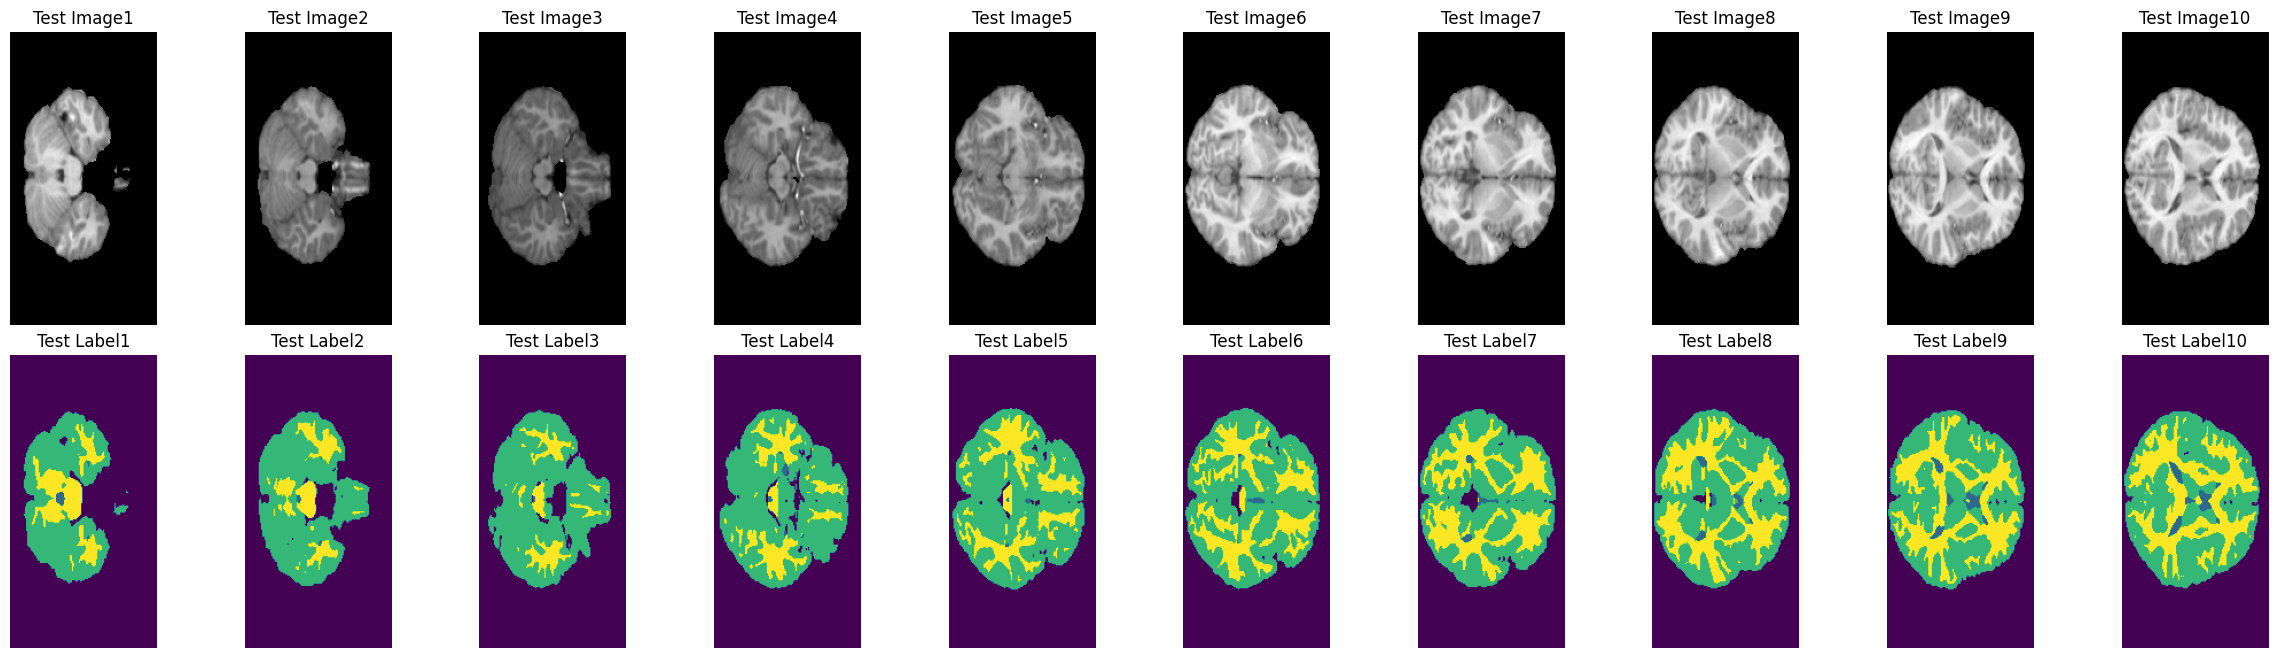

In [2]:
graph_brain()